## Vehicle Detection Project

The purpose of this project is to create a pipeline which can detect vehicles in a video stream and draw bounding boxes around those vehicles.

### Dataset for training and testing of SVM Classifier

The core of this object detection pipeline is the SVM classifer that takes images and classifies them as 'car' or 'not car'. The classifier used here is an implementation of a SVM trained on example images with cars and example images without cars. These images are taken from the GTI and KITTI datasets. The below code creates two lists. One list with paths to images of cars, and another list with paths to images without cars. Two example images from each list are shown below.

num vehicles:  8792
num non-vehicles:  8968


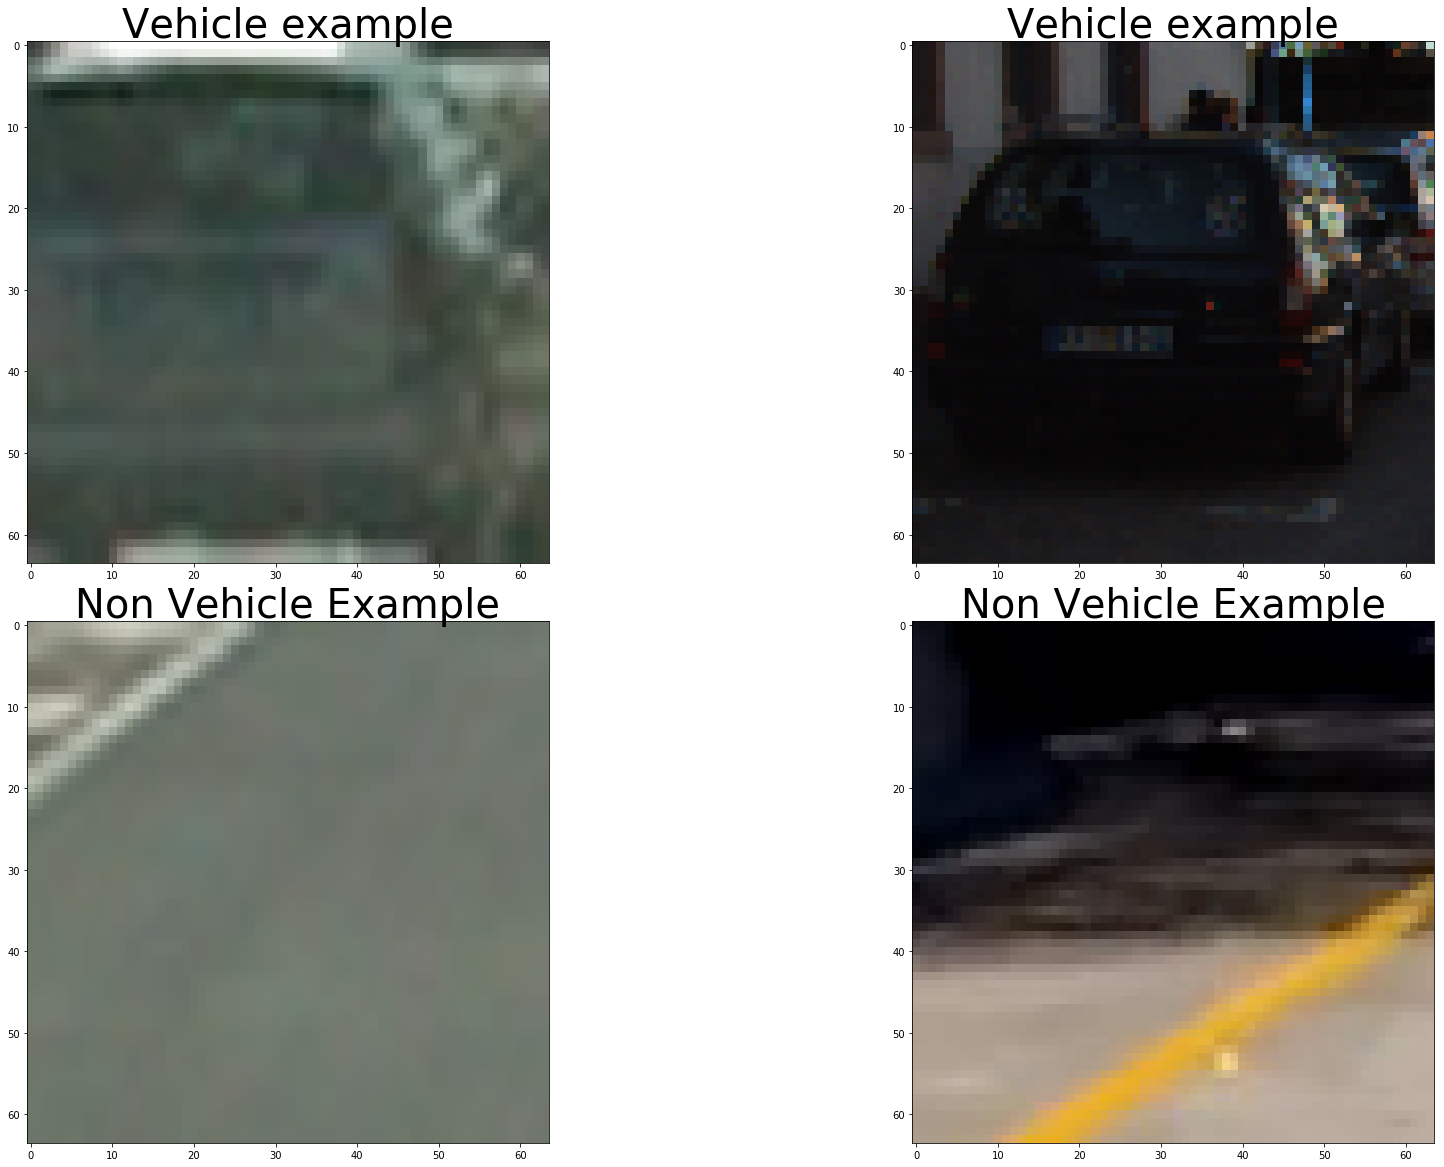

In [1]:
#imports
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import random
import numpy as np
import cv2
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
%matplotlib inline

#Create list of image paths
vehicle_image_paths = glob('./data/vehicles/**/*.png',recursive=True)
non_vehicle_image_paths = glob('./data/non-vehicles/**/*.png',recursive=True)

#print example images
def get_random_image(image_paths):
    return mpimg.imread(image_paths[int(random()*len(image_paths))])

f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(get_random_image(vehicle_image_paths))
ax1.set_title('Vehicle example', fontsize=40)

ax2.imshow(get_random_image(vehicle_image_paths))
ax2.set_title('Vehicle example', fontsize=40)

ax3.imshow(get_random_image(non_vehicle_image_paths))
ax3.set_title('Non Vehicle Example', fontsize=40)

ax4.imshow(get_random_image(non_vehicle_image_paths))
ax4.set_title('Non Vehicle Example', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=1.7, bottom=0.)

print("num vehicles: ", len(vehicle_image_paths))
print("num non-vehicles: ",len(non_vehicle_image_paths))

### Utility functions from Vehicle Detection and Tracking Lesson

Many useful functions for computing HOG features, spatial features, histogram features, image segmentation, and drawing boxes were provided in the course material for the Vehicle Detection and Tracking lesson. The provided functions which I used for this project are copied below.

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

### Feature selection for SVM Classifier

After trying many different combinations and sizes of feature vectors, I settled on the following parameters for the definition of the feature vectors:
* color_space = 'RGB'
* orient = 9
* pix_per_cell = 8
* cell_per_block = 2
* hog_channel = 0
* spatial_size = (16, 16)
* hist_bins = 16
* spatial_feat = True
* hist_feat = False
* hog_feat = True

In [14]:
### Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

These parameters gave me a good balance between training/inference time and classification accuracy. Additionally, with these parameters I observed a very low false negative rate, at the consequence of more false positives than for some other combinations of feature parameters. However, in the heatmap step of this pipeline, I can effectively filter out the false positives. With these parameters, I utilize HOG features and spatial features. The spatial features are simply a downsampled version of the original image while HOG, or Histogram of Oriented Gradients, features retain information about the shapes present in the image. Below I show the red channel for example images as well as plots of the HOG features:

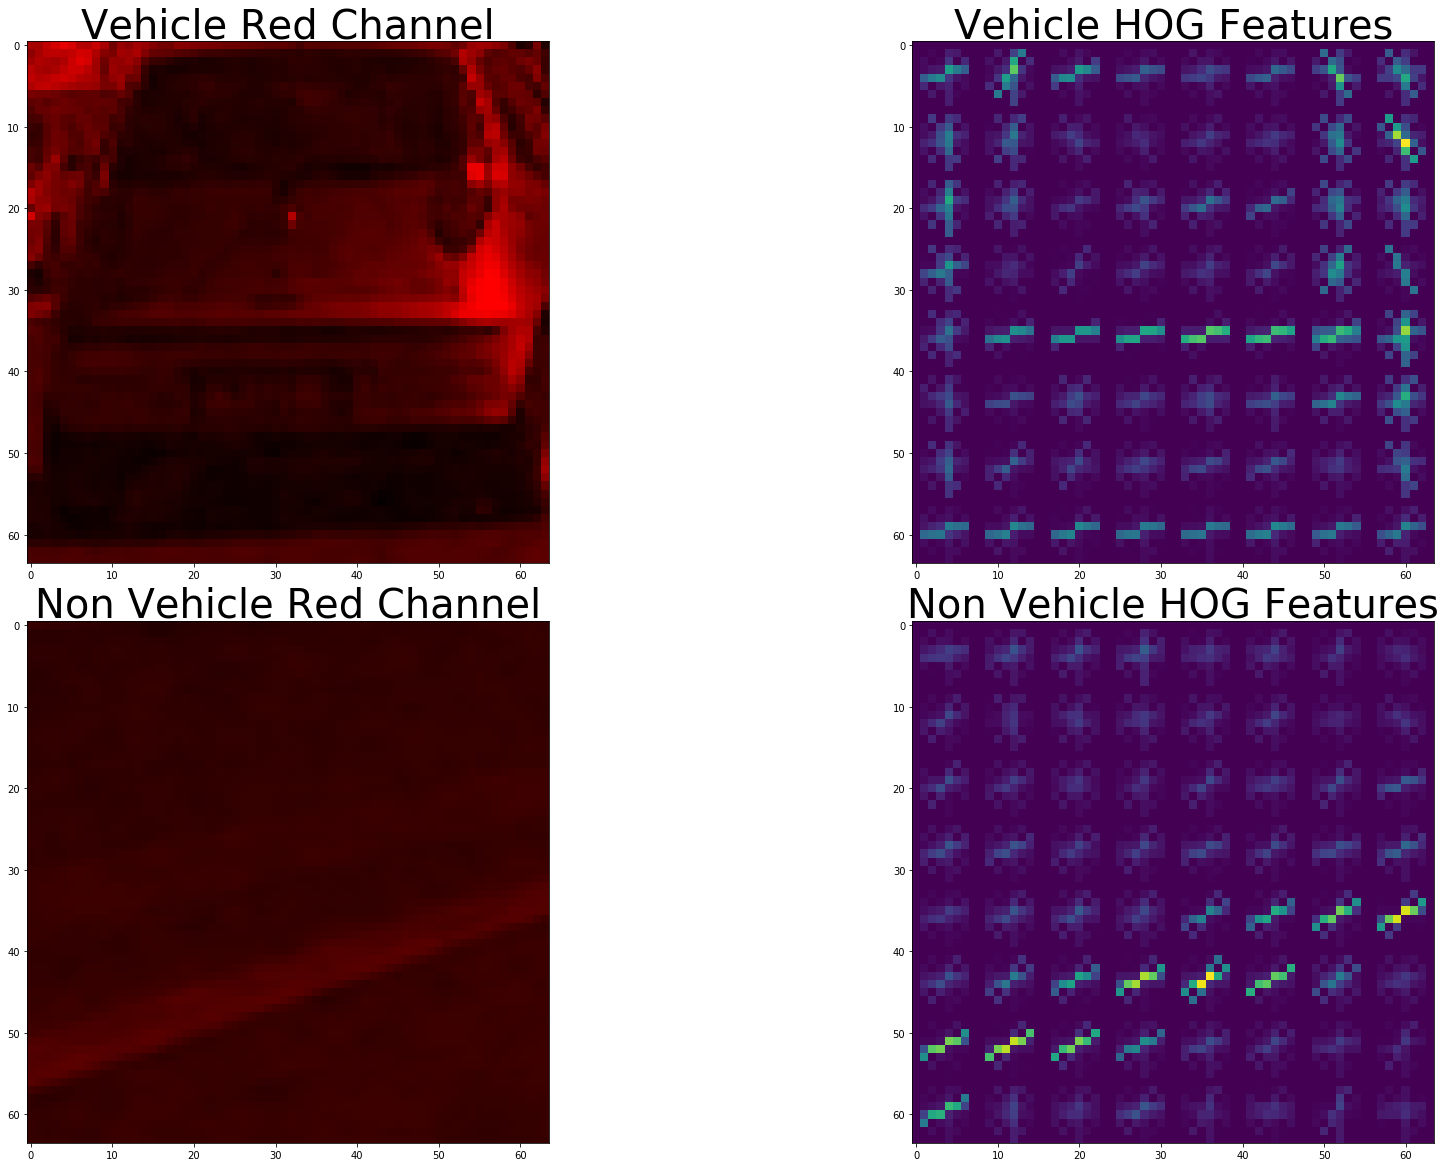

In [19]:
def red_channel(img):
    red = np.copy(img)
    red[:,:,1:3] = 0
    return red

f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()



img = get_random_image(vehicle_image_paths)

ax1.imshow(red_channel(img))
ax1.set_title('Vehicle Red Channel', fontsize=40)

_, img = get_hog_features(img[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
ax2.imshow(img)
ax2.set_title('Vehicle HOG Features', fontsize=40)

img = get_random_image(non_vehicle_image_paths)
ax3.imshow(red_channel(img))
ax3.set_title('Non Vehicle Red Channel', fontsize=40)

_, img = get_hog_features(img[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
ax4.imshow(img)
ax4.set_title('Non Vehicle HOG Features', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=1.7, bottom=0.)

### Training the SVM Classifier

After selection of the feature parameters, the feature vectors are generated, scaled, and used to train the SVM classifier. Normally, I would randomize the placement of positive and negative examples into the training and test sets, but, with this particular dataset, there were many images which were captured from video streams, so they are very similar (in particular, the positive examples from the GTI dataset). To prevent images which are nearly identical from being placed in the training and test sets, I manually segemented the data to avoid this.

In [9]:
# Read in cars and notcars
cars = vehicle_image_paths
notcars = non_vehicle_image_paths

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

test_size = 0.1
num_train_vehicles = int((1-test_size)*len(car_features))
num_train_nonvehicles = int((1-test_size)*len(notcar_features))
X_train_vehicles = scaled_X[:num_train_vehicles]
X_test_vehicles = scaled_X[num_train_vehicles:len(car_features)]
X_train_non_vehicles = scaled_X[len(car_features):len(car_features)+num_train_nonvehicles]
X_test_non_vehicles = scaled_X[len(car_features)+num_train_nonvehicles:]
X_train = np.vstack((X_train_vehicles, X_train_non_vehicles))
X_test = np.vstack((X_test_vehicles, X_test_non_vehicles))

y_train = np.hstack((np.ones(num_train_vehicles), np.zeros(num_train_nonvehicles)))
y_test = np.hstack((np.ones(len(car_features)-num_train_vehicles), np.zeros(len(notcar_features)-num_train_nonvehicles)))


print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2532
11.85 Seconds to train SVC...
Test Accuracy of SVC =  0.9713


### Image segmentation and segment classification using sliding windows

With the trained SVM classifier, I can now perform inference on images to determine if they contain a vehicle. First, I defined a region of interest within the frame. I only search for vehicles within this region of interest. By doing such, I reduce false positives and reduce the time it takes for my pipeline to process a frame. Next, I extract sections of the region of interest and resize those sections to 64x64 so that I can generate feature vectors which are the same length as those used to train my classifier. After scaling the generated feature vectors, I can pass them to my classifier to determine if there is a vehicle in this segment. I used a sliding window approach to segment the region of interest and I experimented with different overlap percentages, segment widths/heights, and even multiple sizes of segments. I found that using smaller windows in addition to the bigger windows to try and capture near and far vehicle perspectives did not work very well and the small windows in particular took a lot of time to process. In the end, I chose a single 96x96 window size and 75% overlap. An example with overlapping postive image segments is shown below:

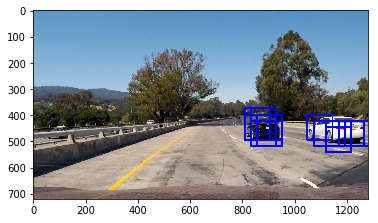

In [10]:
image = mpimg.imread('test_images/test1.jpg')

# Check the SVC performance on first test image
def process_frame(img,return_hot_windows=False):
    algo_img = img.astype(np.float32)/255

    y_start_stop = [350,None]
    x_start_stop = [784,None]
    windows = slide_window(algo_img, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                           xy_window=(96, 96), xy_overlap=(0.75, 0.75))

    hot_windows = search_windows(algo_img, windows, svc, X_scaler, color_space=color_space,
                                 spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
                                 pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,
                                 hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat,
                                 hog_feat=hog_feat)
    if return_hot_windows:
        return hot_windows
    else:
        return draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6)  

plt.imshow(process_frame(image))

### Vehicle Tracking with a heatmap

To turn the raw vehicle detections into reliable tracks, I use a heat map. For every image segment where a vehicle is detected, I add heat using the functions provided in the lesson.

In [ ]:
#heat map functions from lesson
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

When a vehicle is present in a section of the frame, multiple image segements are classified as part of that vehicle due to the overlap and size of the vehicle in the image. A threshold is then applied to the heatmap and the label function from scipy is used to generate bounding boxes for the hot areas. The heat map for the frame is show in the below image: 

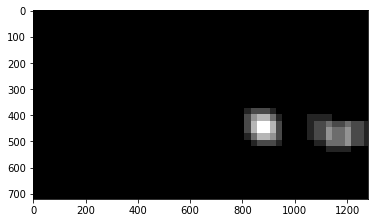

In [27]:
img = mpimg.imread('test_images/test1.jpg')

hot_windows = process_frame(img,return_hot_windows=True)
example_heatmap = np.zeros(img.shape[0:2])
add_heat(example_heatmap,hot_windows)
example_heatmap = apply_threshold(example_heatmap,0)
scaling_factor = 255/np.max(example_heatmap)
example_heatmap = example_heatmap * scaling_factor

plt.imshow(example_heatmap,cmap='gray')

All that remains is to update the heatmap on a frame-by-frame basis and drawing the bounding boxes for the hot areas on the original frame:

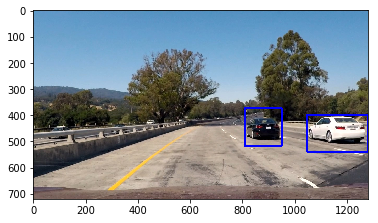

In [11]:
def update_heatmap_and_draw(img,heatmap,threshold=0):
    hot_windows = process_frame(img,return_hot_windows=True)
    frame_heatmap = np.zeros_like(heatmap)
    add_heat(frame_heatmap,hot_windows)
    heatmap[frame_heatmap < 1] = 0
    heatmap = heatmap + frame_heatmap
    render_heatmap = np.copy(heatmap)
    apply_threshold(render_heatmap,threshold)
    labels = label(render_heatmap)
    return heatmap, draw_labeled_bboxes(img, labels)


image = mpimg.imread('test_images/test1.jpg')
heatmap = np.zeros(image.shape[0:2])

_ , processed_img = update_heatmap_and_draw(image,heatmap)
plt.imshow(processed_img)

3.06 seconds to process 6 frames...


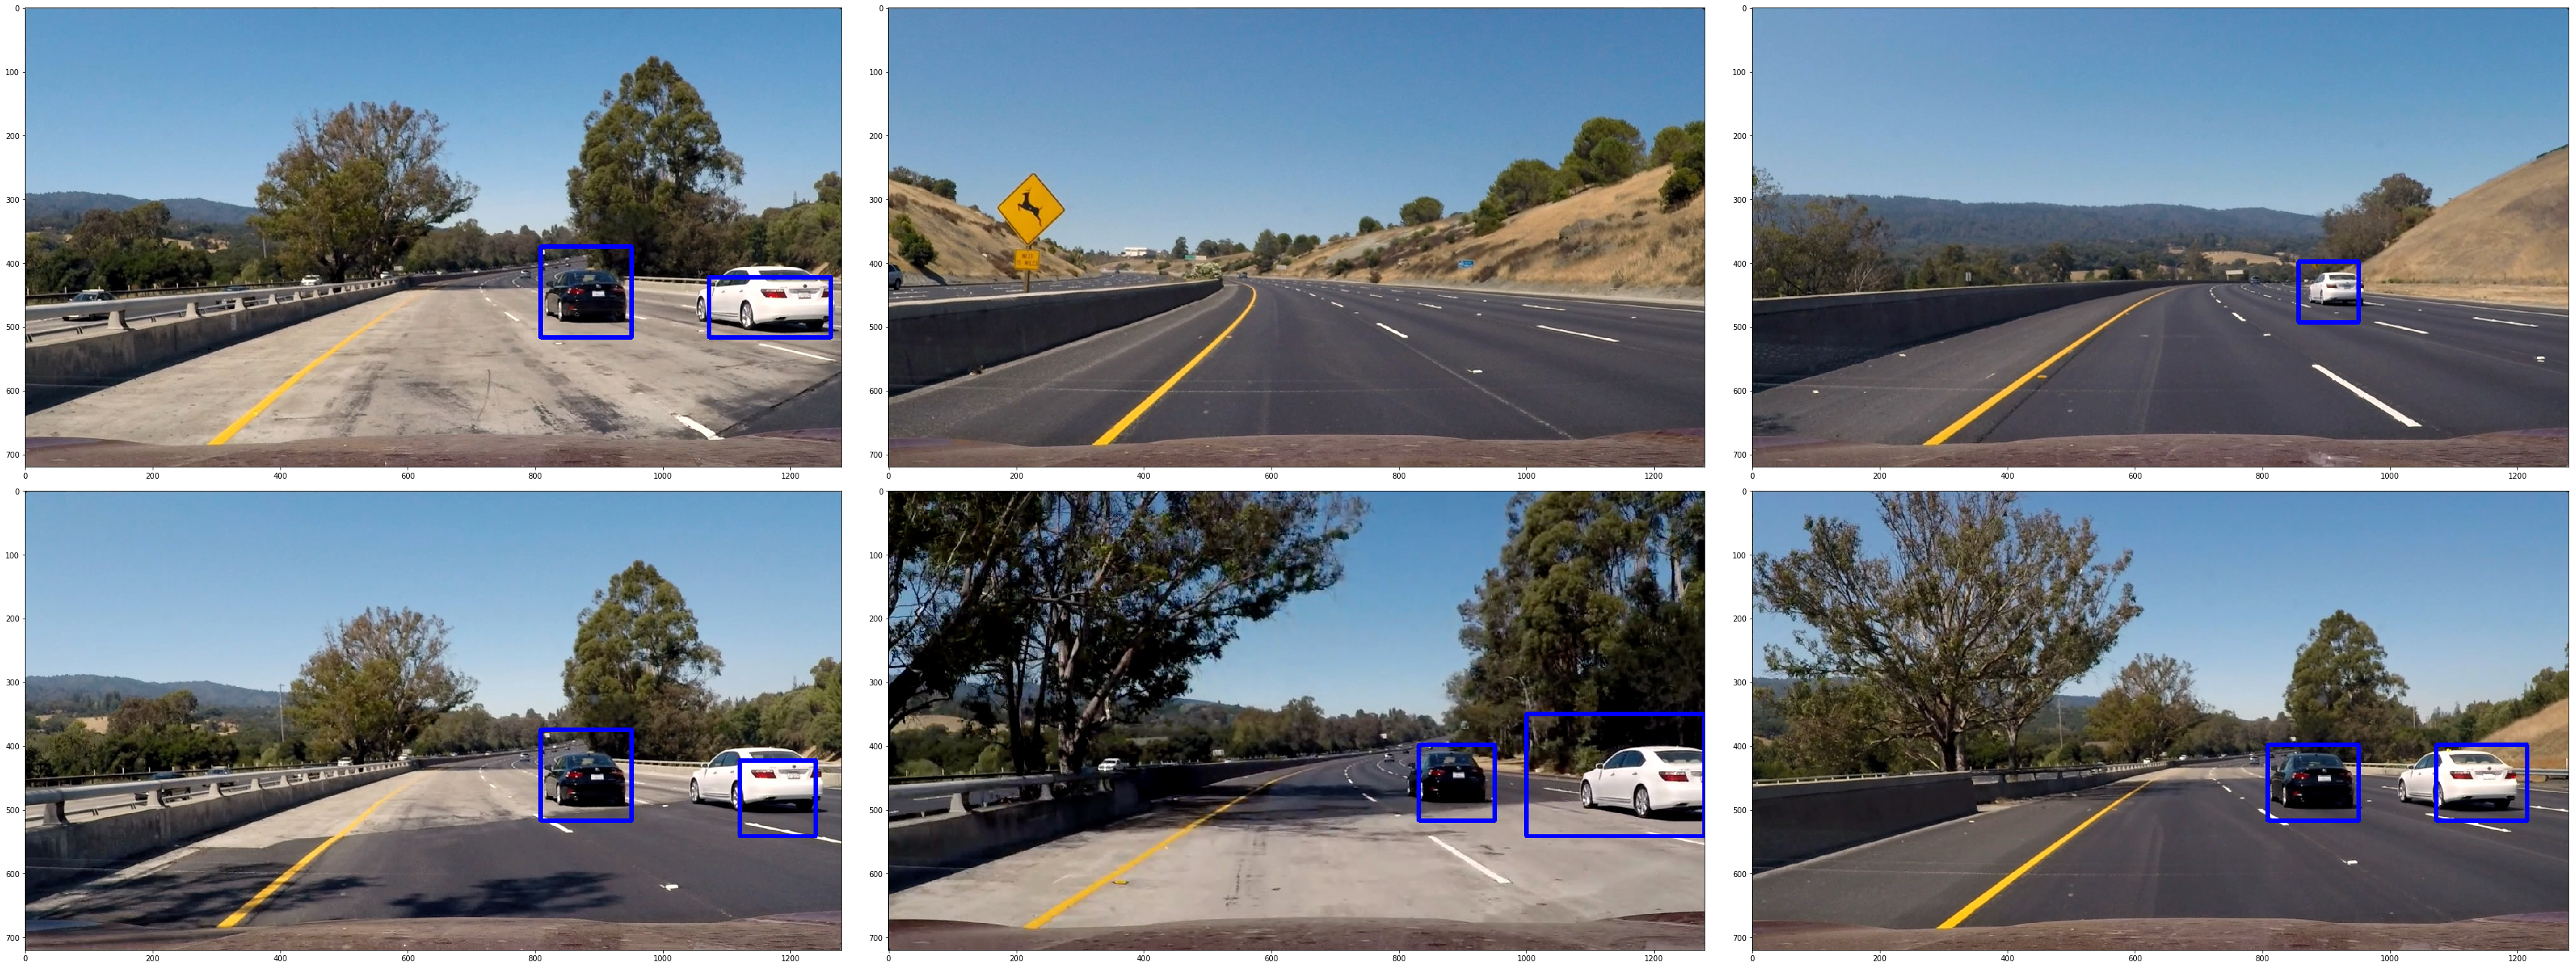

In [12]:
#process test frames
image_paths = glob("./test_images/*.jpg")

f, axes = plt.subplots(2, 3, figsize=(48,18))
f.tight_layout()

axes = [ax for row in axes for ax in row]

def plot_test_results(img_paths,axes):
    for img_path,ax in zip(img_paths,axes):
        img = mpimg.imread(img_path)
        heatmap = np.zeros(img.shape[0:2])
        _ , img = update_heatmap_and_draw(img,heatmap,threshold=2)
        ax.imshow(img)

t=time.time()
plot_test_results(image_paths,axes)
t2 = time.time()
print(round(t2-t, 2), 'seconds to process 6 frames...')

In [13]:
# Run algorithm on project video

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

video_frame_example = mpimg.imread('test_images/test1.jpg')
video_heatmap = np.zeros(video_frame_example.shape[0:2])

def process_video_frame(img):
    global video_heatmap
    video_heatmap, img = update_heatmap_and_draw(img,video_heatmap,threshold=90)
    return img
    

output = 'output.mp4'
input_video = VideoFileClip("project_video.mp4")
output_clip = input_video.fl_image(process_video_frame)
%time output_clip.write_videofile(output,audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [08:20<00:00,  2.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 7min 51s, sys: 18.6 s, total: 8min 10s
Wall time: 8min 21s


In [8]:
#play video
from IPython.display import HTML
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(output))

### Discussion

For me, the most challenging part of this project was selecting the right parameters for the feature vector used by the SVM classifier. This took me a lot of trial and error and was a very manual process. A better approach would be to apply sklearn's GridSearchCV to search combinations of parameters. However, the classifier with the highest accuracy wasn't the best one to use for the pipeline as I found that it seemed to generate more false positives than the one that I ended up using. Some limitations of this approach are that we do not use images of oncoming cars to train the classifer, so it would likely have poor performace on oncoming traffic. Also, the heatmap implementaion performs best then the detected vehicle has a static location in frame or moves very slowly in the frame. A fast moving vehicle would not build heat at the same pixels and would be harder to detect using this method.
